In [1]:
cd ../

C:\Users\teruto\Desktop\sourcecode\livedoor-news-clustering


In [2]:
cd data

C:\Users\teruto\Desktop\sourcecode\livedoor-news-clustering\data


In [3]:

import numpy as np
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import jaconv

In [4]:
"""
前処理：タイトルとカテゴリを抽出し、データセットを分割
"""
import glob
from sklearn.model_selection import train_test_split

x, t = list(), list()
for fname in sorted(glob.glob("./*.xml")):
    fin = open(fname,'r',encoding="utf-8_sig")
    for line in fin:
        if not line.strip().startswith('<field name="title">'):
            continue
        # タイトル
        text = line.strip().replace('<field name="title"><![CDATA[', '').replace("]]></field>", "")
        x.append(text)
        # カテゴリ
        t.append(fname.split("/")[-1].replace(".xml", ""))
    fin.close()

print("len(x): %d" % len(x))
print(x[:3])
print("len(t): %d" % len(t))
print(t[:3])

# まず訓練&検証用(90%)と評価用(10%)に分割
x_traindev, x_test, t_traindev, t_test = train_test_split(x, t, test_size=0.1, random_state=0)

# さらに訓練用(90%)と検証用(10%)に分割
x_train, x_dev, t_train, t_dev = train_test_split(x_traindev, t_traindev, test_size=0.1, random_state=0)

# train:dev:test = 5,000:500:500 に分割
x_train, t_train = x_train[:5000], t_train[:5000]
x_dev, t_dev = x_dev[:500], t_dev[:500]
x_test, t_test = x_test[:500], t_test[:500]

# ラベルをIDに変換
label2id = dict()
for label in set(t):
    label2id[label] = len(label2id)
t_train = [label2id[label] for label in t_train]
t_dev = [label2id[label] for label in t_dev]
t_test = [label2id[label] for label in t_test]

print("train : dev : test = %d : %d : %d" % (len(x_train), len(x_dev), len(x_test)))
for text, label in zip(x_train[:3], t_train[:3]):
    print(str(label) + "\t" + text)
print(label2id)

len(x): 7367
['友人代表のスピーチ、独女はどうこなしている？', 'ネットで断ち切れない元カレとの縁', '相次ぐ芸能人の“すっぴん”披露\u3000その時、独女の心境は？']
len(t): 7367
['.\\dokujo-tsushin', '.\\dokujo-tsushin', '.\\dokujo-tsushin']
train : dev : test = 5000 : 500 : 500
2	本田圭佑のイチロー似作文が話題　「必ず世界一になる」 　 
3	【週末映画まとめ読み】“美しすぎる知の女神”優木まおみが「触らせて」
6	自宅で簡単！　ヨガポーズで「花粉症」をスッキリ解消
{'.\\kaden-channel': 0, '.\\dokujo-tsushin': 1, '.\\sports-watch': 2, '.\\movie-enter': 3, '.\\livedoor-homme': 4, '.\\smax': 5, '.\\peachy': 6, '.\\it-life-hack': 7, '.\\topic-news': 8}


In [24]:
#特徴量の抽出
def add_flags_nums(df):
    
    #テキストの長さ
    df["text_length"] = np.zeros(df.shape[0])
    for idx in range(df.shape[0]):
        df["text_length"].loc[idx] = len(df["text"].loc[idx])
    df["text_length"] = df["text_length"].astype(np.float64)
    
    #日付が入っているか
    df["is_year"] = df['text'].str.contains(r'(0+年)')
    df["is_year"] = (df["is_year"]*1).astype(np.float64)
    df["is_month"] = df['text'].str.contains(r'(0+月)')
    df["is_month"] = (df["is_month"]*1).astype(np.float64)
    df["is_date"] = df['text'].str.contains(r'(0+日)')
    df["is_date"] = (df["is_date"]*1).astype(np.float64)
    df["is_time"] = df['text'].str.contains(r'(0+時)')
    df["is_time"] = (df["is_time"]*1).astype(np.float64)
    df["text"] = df["text"].str.replace(r'(0+年)',"")
    df["text"] = df["text"].str.replace(r'(0+月)',"")
    df["text"] = df["text"].str.replace(r'(0+日)',"")
    df["text"] = df["text"].str.replace(r'(0+時)',"")
    
    
    #はてなの個数
    df["num_hatena"] = df["text"].str.count('\?').astype(np.float64)
    df["num_bikkuri"] =df["text"].str.count('!').astype(np.float64)
    
    #映画の文字列
    df["is_eiga"] = df["text"].str.contains("映画")
    df["is_eiga"] = (df["is_eiga"]*1).astype(np.float64)
    
    #変なかっこがあるか
    df["is_henkakko"] = df["text"].str.contains("【")
    df["is_henkakko"] = (df["is_henkakko"]*1).astype(np.float64)
    df["text"] = df["text"].str.replace("【","")
    df["text"] = df["text"].str.replace("】","")
    
    #普通カッコがあるか
    df["is_normalkakko"] = df["text"].str.contains("｢")
    df["is_normalkakko"] = (df["is_normalkakko"]*1).astype(np.float64)
    df["text"] = df["text"].str.replace("｢","")
    df["text"] = df["text"].str.replace("｣","")
    
    #白カッコがあるか
    df["is_whitekakko"] = df["text"].str.contains("『")
    df["is_whitekakko"] = (df["is_whitekakko"]*1).astype(np.float64)
    df["text"] = df["text"].str.replace("『","")
    df["text"] = df["text"].str.replace("』","")
    
    #vol.数字があるかどうか
    df["is_vol"] = df["text"].str.contains("vol.0")
    df["is_vol"] = (df["is_vol"]*1).astype(np.float64)
    df["text"] = df["text"].str.replace("vol.0","")
    
    #スポーツウォッチか
    df["is_sports"] = df["text"].str.contains("sports watch")
    df["is_sports"] = (df["is_sports"]*1).astype(np.float64)
    df["text"] = df["text"].str.replace("sports watch","")
    
    return df

In [7]:
#テキストのクリーニング
def cleaning(df):
    #urlの削除
    #df["text"] = df["text"].replace(r'(https?://[\w/:%#\$&\?\(\)~\.=\+\-]+)',"",regex=True)
    #改行コードの削除
    df["text"] = df["text"].replace("\\u3000",'')
    #全角スペースを半角スペースに
    df["text"] = jaconv.z2h(df["text"].str,digit=True, ascii = True) 
    #大文字を小文字に
    df["text"] = df["text"].str.lower()
    #数字を0に置き換える
    df["text"] = df["text"].str.replace(r'([0-9])',"0",regex = True)    
    df["text"]

    return df

In [8]:
#1文字の単語を消す
def del_one(df):
    delonelist = list()
    for i in range(df.shape[0]):
        wakati = df["text_wakati"].values[i]
        del_one = ""
        for idx in range(len(wakati)):
            if len(str(wakati[idx])) > 1:
                del_one += (wakati[idx]+" ")
        delonelist.append(np.array(del_one))
    df["text_del_one"] = np.array(delonelist)
    return df

In [9]:
from janome.tokenizer import Tokenizer
def wakati(df):
    df["text_wakati"] = str()
    t= Tokenizer()

    for idx in range(0,df.shape[0]):
        df["text_wakati"].loc[idx] = [token.base_form for token in t.tokenize(df["text"].loc[idx])]
    return df

In [10]:

#wakati をスペース区切りのstrに変換
def wakati_toString(df):
    wakati_str = list()
    for i in range(df.shape[0]):
        wakati = df["text_wakati"].values[i]
        s = ""
        for idx in range(len(wakati)):
            s += (wakati[idx]+" ")
        wakati_str.append(np.array(s))
    df["text_wakati"] = np.array(wakati_str)
    return df

In [25]:

#DataFrame変換
train_df = pd.DataFrame({"flg":t_train,"text":x_train})
dev_df = pd.DataFrame({"flg":t_dev,"text":x_dev})
test_df = pd.DataFrame({"flg":t_test,"text":x_test})
test_df

#メソッド適用
train_df = cleaning(train_df)
dev_df= cleaning(dev_df)
test_df = cleaning(test_df)

train_df = add_flags_nums(train_df)
dev_df = add_flags_nums(dev_df)
test_df = add_flags_nums(test_df)

train_df = wakati(train_df)
dev_df = wakati(dev_df)
test_df = wakati(test_df)

train_df = del_one(train_df)
dev_df = del_one(dev_df)
test_df = del_one(test_df)

train_df = wakati_toString(train_df)
dev_df = wakati_toString(dev_df)
test_df = wakati_toString(test_df)

train_df.to_csv("./preprosessing_train.csv")
dev_df.to_csv("./preprosessing_dev.csv")
test_df.to_csv("./preprosessing_test.csv")

In [12]:
train_df.columns

Index(['flg', 'text', 'text_length', 'is_year', 'is_month', 'is_date',
       'is_time', 'num_hatena', 'num_bikkuri', 'is_eiga', 'is_henkakko',
       'is_normalkakko', 'is_whitekakko', 'is_vol', 'is sports', 'text_wakati',
       'text_del_one'],
      dtype='object')

In [26]:
X_df_train = train_df[['text_length', 'is_year', 'is_month', 'is_date',
       'is_time', 'num_hatena', 'num_bikkuri', 'is_eiga', 'is_henkakko',
       'is_normalkakko', 'is_whitekakko', 'is_vol', 'is_sports',
       'text_del_one']]
Y_df_train = train_df["flg"].astype(np.int64)
X_train =  X_df_train.values
y_train = Y_df_train.values

In [28]:
X_df_test = test_df[['text_length', 'is_year', 'is_month', 'is_date',
       'is_time', 'num_hatena', 'num_bikkuri', 'is_eiga', 'is_henkakko',
       'is_normalkakko', 'is_whitekakko', 'is_vol', 'is_sports',
       'text_del_one']]
Y_df_test = test_df["flg"].astype(np.int64)
X_test =  X_df_test.values
Y_test = Y_df_test.values

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
cv = CountVectorizer()
# トレーニング用データにCountVectorizerを適用
X_train = cv.fit_transform(X_train[:,13])
# バリデーション用データにCountVectorizerを適用
X_test = cv.transform(X_test[:,13])

In [33]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=500,
                                    random_state=1)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=1)

In [40]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score, recall_score,f1_score
import seaborn as sns
def result_heatmap(Y_test,Y_pred):
    print("正解率:"+str(accuracy_score(Y_test, Y_pred)))
    cm = confusion_matrix(Y_test, Y_pred)
    sns.heatmap(cm,annot=True, cmap='Blues')

正解率:0.668


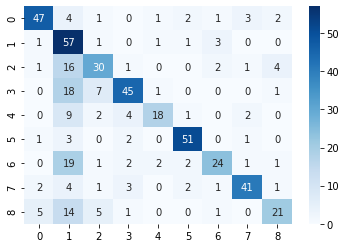

In [42]:
#普通にやると全部違う方に分類される
result_heatmap(Y_test,y_pred)
